In [1]:
# run the header that sets up the environment

if "already_run" not in globals():
    globals()["already_run"] = True
    
    %run header.ipynb
    load_packages()
    change_wordir()

colors, colours = colourblind_palette("own")


analysis = "DIRKs"

#model = "cyclic_2021"
#model = "new_PSI"
# model = "new_PSII"
# model = "new_b6f"
model = "latest_dev"

m = load_model(model)

Could not find cannot import name 'dopri5' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


1.30.0

succesfully loaded latest_dev :D


In [2]:
y0 = {
    "PQ": 11.027139850905353,       "PC": 1.8895071932002812,           "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,       "NADPH": 0.48821037006737366,       "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,      "Psbs": 0.9607146039898598,         "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,      "BPGA": 0.0005355311557548053,      "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,    "FBP": 0.006126990841013743,        "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,      "G1P": 0.041575582577936025,        "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,     "E4P": 0.00732079113061801,         "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,     "RUBP": 0.13153657267999222,        "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,    "ASC": 9.999994138785292,           "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,   "GSH": 9.999999991725186,           "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,                   "E_inactive": 4.7368421052631575,
    "P700FA": 1.506615384275408,            #eq at pfd 800       #"PSItot": 2.5, (in parameter vector of Matuszynska)
    "P700+FA-": 0.019197449388051676,
    "P700FA-": 0.028144516332212766,
    "B0": 1.9379789566530539,  # eq at pfd 800
    "B1": 9.786232812526368e-08,
    "B2": 0.5620208537555176
}

In [3]:
# def DIRK(s: Simulator, pre_relax_time: float, pfd_illum: float, 
#           relax_time: float, relax_pfd: float, post_relax_time: float):
#      """
#      illumination to steady state -> dark (relaxation) -> illumination
#      """     
#      # Compute cumulative time points for each simulation phase
#      time_points = it.accumulate([pre_relax_time, relax_time, post_relax_time]) #1) i.; 2) i. + ii.; 3) i. + ii. + iii.

#      # Corresponding PFD levels for each phase
#      pfd_levels = [pfd_illum, relax_pfd, pfd_illum]

#      # Run the simulation for each phase
#      for time, pfd in tqdm(zip(time_points, pfd_levels)): # zip: eg. "[(1, 800), (3, 0), (6, 800)]"
#           s.update_parameter("pfd", pfd)
#           #print(f"Time: {time}, PFD: {pfd}")
#           s.simulate(time) 

def DIRK(s: Simulator, pre_relax_time: float, pfd_illum: float, 
        relax_time: float, relax_pfd: float, post_relax_time: float):
    """
    illumination to steady state -> dark (relaxation) -> illumination
    simulator has to be initialised
    """
    #get steady state
    s.update_parameter("pfd", pfd_illum)
    s.simulate_to_steady_state()
    y1 = s.get_new_y0()
    if y1 is None:
        raise ValueError("Modelbase says NO")
    s.initialise(y1)
    
    time_points = it.accumulate([pre_relax_time, relax_time, post_relax_time]) #1) i.; 2) i. + ii.; 3) i. + ii. + iii.
    pfd_levels = [pfd_illum, relax_pfd, pfd_illum]
    
    for time, pfd in tqdm(zip(time_points, pfd_levels)): # zip: eg. "[(1, 800), (3, 0), (6, 800)]"
        s.update_parameter("pfd", pfd)
        #print(f"Time: {time}, PFD: {pfd}")
        s.simulate(time)
    
    c = s1.get_full_results_df()
    v = s1.get_fluxes_df()

    c.index = c.index - pre_relax_time # shift the index such that event starts at 0
    v.index = v.index - pre_relax_time # shift the index such that event starts at 0

    return c, v

# DIRK

In [4]:
"""
Prior to the measurements, attached leaves of Col-0(black curves) and cfq (red curves) 
were illuminated for at least 20 min with  300 µmol photons·m−2·s−1at and low(50 ppm, thick curves) CO2. 
Kinetics of absorbance changes were measuredusing the IDEASpec device as described in the text. 
As shown in the coloredbands at the top of the graph, the actinic illumination was switched off for 100 ms time intervals 
starting at time zero. Data is plotted as the fraction of P700 oxidized determined by the differences 
in absorbance changes at810–940 nm, normalized to the maximum absorbance changes observedunder 
far red illumination followed by a saturating ﬂash

https://www.researchgate.net/publication/316674887_Chloroplast_ATP_Synthase_Modulation_of_the_Thylakoid_Proton_Motive_Force_Implications_for_Photosystem_I_and_Photosystem_II_Photoprotection
"""

s1 = Simulator(m)
s1.initialise(y0)

pre_relax_time = 0.025
pfd_illum = 300
relax_time = 0.1
relax_pfd = 10
post_relax_time = 0.1

c, v = DIRK(s1, pre_relax_time, pfd_illum, relax_time, relax_pfd, post_relax_time) 

3it [00:00,  3.80it/s]


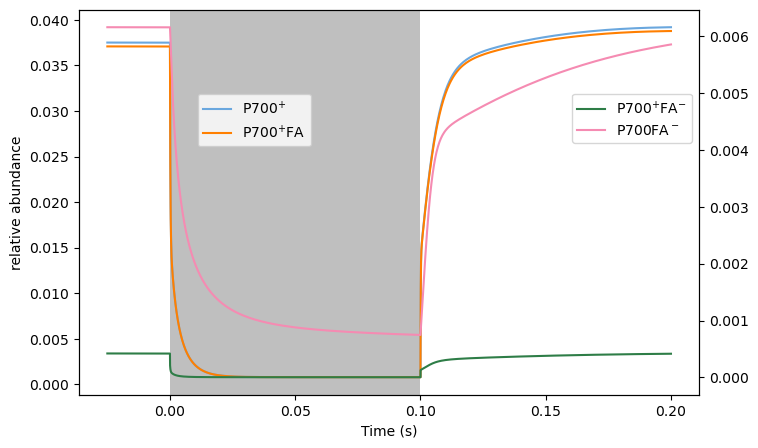

In [15]:
fig,ax1=plt.subplots(figsize=(8,5))
ax2 = ax1.twinx()

#ax 1
ax1.plot(c["rel_P700+"], label = "P700$^{+}$", color=colors[0])
ax1.plot(c["rel_P700+FA"], label = "P700$^{+}$FA", color=colors[1])

ax2.plot(c["rel_P700+FA-"], label = "P700$^{+}$FA$^{-}$", color=colors[2])
if model != "cyclic_2021":
       ax2.plot(c["rel_P700FA-"], label = "P700FA$^-$", color=colors[3])


ax1.set(#ylim=(0, 0.15),
       xlabel=("Time (s)"),
       ylabel=("relative abundance"))
ax1.axvspan(0, relax_time, color='grey', alpha=0.5, lw=0)
ax1.legend(loc = "upper left")

ax2.set(#ylim=(0, 0.0015)
       )

ax1.legend(loc = "upper left", bbox_to_anchor=(0.18, 0.8))
ax2.legend(loc = "upper right", bbox_to_anchor=(1, 0.8))
       
plt.show()

In [6]:
save_fig(fig, model, analysis, "P700p")